# 1a

In [92]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
import seaborn
seaborn.set(style="white", context="notebook", font_scale=1.5,
            rc={"axes.grid": True, "legend.frameon": False,
"lines.markeredgewidth": 1.4, "lines.markersize": 10})
from collections import OrderedDict
from scipy import linalg

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
x = np.arange(0, 1, .05)#0.05)
y = np.arange(0, 1, .05)#0.05)

numberOfObservations = len(x)
xPlot, yPlot = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(xPlot, yPlot)

# Plot the surface.
surf = ax.plot_surface(xPlot, yPlot, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [102]:
class LeastSquares:
    """ 
    Least squares estimation of 2D function.
    Takes in meshgrid versions of x, y and z
    """
    
    def __init__(self, xPlot, yPlot, zPlot, degree, trueFunction=False, lambdaValue=None):
        if trueFunction:
            self.trueFunction = trueFunction
        if lambdaValue != None:
            self.lambdaValue = lambdaValue
        else:
            self.lambdaValue = 0.
        self.xOrg, self.yOrg = xPlot[0], yPlot[:,0]
        self.numberOfObservations = len(self.xOrg)
        self.xPlot, self.yPlot, self.zPlot = xPlot, yPlot, zPlot
        #self.x, self.y, self.z = xPlot.reshape(-1, 1), yPlot.reshape(-1, 1), zPlot.reshape(-1, 1)
        #self.x, self.y, self.z = np.ravel(xPlot), np.ravel(yPlot), np.ravel(zPlot)
        self.x, self.y, self.z = np.reshape(xPlot, -1, 1), np.reshape(yPlot, -1, 1), np.reshape(zPlot, -1, 1)

        self.degree = degree
        
    def createDesignMatrix(self):
        x, y = self.x, self.y
        #XHat = np.c_[x, y] 
        self.XHat = np.c_[x, y] 
        poly = PolynomialFeatures(self.degree)
        self.XHat = poly.fit_transform(self.XHat)
        #self.XHat = poly.fit_transform(XHat)

    def estimate(self):
        XHat = self.XHat
        XHatTdotXHatShape = np.shape(XHat.T.dot(XHat))
        
        # Ridge Inverson
        #self.betaHat = np.linalg.inv(XHat.T.dot(XHat) + \
         #                            lambdaValue*np.identity(XHatTdotXHatShape[0])).dot(XHat.T).dot(self.z)
        
        # OLS inversion
        #self.betaHat = np.linalg.inv(XHat.T.dot(XHat)).dot(XHat.T).dot(self.z)
        
        # Linear system OLS
        #self.betaHat = np.linalg.solve(np.dot(XHat.T, XHat), np.dot(XHat.T, self.z))
        
        # Linear system, Ridge. NOT WORKING.
        #self.betaHat = np.linalg.solve(np.dot(XHat.T, XHat) + lambdaValue*np.identity(XHatTdotXHatShape[0]),\
         #                              np.dot(XHat.T, self.z))
        
        # SVD Ridge
        alphas = np.zeros(1)
        alphas[0] = self.lambdaValue
        U, s, Vt = linalg.svd(self.XHat, full_matrices=False)
        d = s / (s[:, np.newaxis].T ** 2 + alphas[:, np.newaxis])
        self.betaHat = np.dot(d * U.T.dot(self.z), Vt).T
        self.betaHat = np.squeeze(self.betaHat)
        #print('shape beta ', np.shape(self.betaHat), 'type beta', type(self.betaHat))
    
    def predict(self):
        self.zPredict = self.XHat.dot(self.betaHat)

        
    def plot(self):
        xPlot, yPlot, zPlot = self.xPlot, self.yPlot, self.zPlot
        zPredict = self.zPredict
        #z = self.z
        zPredictPlot = (np.reshape(zPredict, np.shape(zPlot))).T
        #zPredictPlot = zPredictPlot.T
        
        # Plot
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        surf = ax.plot_surface(xPlot, yPlot, zPredictPlot, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False) 
        #ax.set_zlim(-1.50, 25.0)
        #ax.set_zlim(-0.10, 1.40)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        fig.colorbar(surf, shrink=0.5, aspect=5)
        ax.set_title('Predicted')
        plt.show()
        
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        surf = ax.plot_surface(xPlot, yPlot, zPlot, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False) 
        #ax.set_zlim(-1.50, 25.0)
        #ax.set_zlim(-0.10, 1.40)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        fig.colorbar(surf, shrink=0.5, aspect=5)
        ax.set_title('True')
        plt.show()        
        
        
    def calculateErrorScores(self):
        from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
        z, zPredict = self.z, self.zPredict
        mse = mean_squared_error(z, zPredict)
        r2 = r2_score(z, zPredict)
        #print('zPredict inside errorScores', zPredict)
        print("Mean squared error: %.4f" % mse)
        print('R2 score: %.4f' % r2)
        #return mse, r2

    def calculateVarianceBeta(self):
        lambdaRidge = 0
        XHat = self.XHat
        betaHat = self.betaHat
        z = self.z

        # Source Ridge estimator variance: https://arxiv.org/pdf/1509.09169.pdf
        shapeXXT = np.shape(XHat.T.dot(XHat))

        yFitted = XHat.dot(betaHat)
        mse = 1/(len(x) -1)*np.sum((z - yFitted)**2)

        coefficientVariancesSLR = np.linalg.inv(XHat.T.dot(XHat)).dot(mse)
        W = np.linalg.inv(XHat.T.dot(XHat) + lambdaRidge*np.eye(shapeXXT[0], shapeXXT[1])).dot(XHat.T).dot(XHat) 
        self.varBeta = W.dot(coefficientVariancesSLR).dot(W.T)
        self.varBeta = np.diag(self.varBeta)
        #self.varBeta = np.diag(coefficientVariancesSLR)
        self.varOLS = np.diag(coefficientVariancesSLR)
        
    def movingAvg(self, array):
        n = len(array)
        cumsum  = np.cumsum(array)
        movingAverage  = np.cumsum(array)
        for counter in range(len(array)):
            movingAverage[counter] = cumsum[counter]/(counter+1)
        return movingAverage    
    
    def runningVariance(self, betaList):
        betaList = np.array(betaList)
        numberOfRuns, numberOfBetas = np.shape(betaList)
        varianceMatrix = np.zeros((numberOfRuns, numberOfBetas))

        for runNumber in range(numberOfRuns):
            for betaNumber in range(numberOfBetas):
                varianceMatrix[runNumber, betaNumber] = np.var(betaList[0:runNumber+1, betaNumber])
        return varianceMatrix
    
    def runningVarianceVector(self, betaList):
        betaList = np.array(betaList)
        numberOfRuns = len(betaList)
        varianceVector = np.zeros(numberOfRuns)

        for runNumber in range(numberOfRuns):
            varianceVector[runNumber] = np.var(betaList[0:runNumber+1])
        return varianceVector
    
    
    def errorBootstrap(self, bootstraps=2, plot=False): 
        self.mseBootstrap = np.zeros(bootstraps)
        self.R2Bootstrap = np.zeros(bootstraps)
        self.bootstraps = bootstraps
        betaList = [] # For variance calculation
        #VBT = []
        self.error2 = np.zeros(bootstraps)
        #averageZ = 0
        zPredictDict = OrderedDict() # Bias-variance decomposition
        noiseDict = OrderedDict()
        noiseDict2 = OrderedDict()
        totalErrorDict = OrderedDict()
        varianceDict = OrderedDict()

        for i in range(self.numberOfObservations):
            for j in range(self.numberOfObservations):
                zPredictDict[i, j]  = []
                noiseDict[i, j]      = []
                #noiseDict2[i, j]      = []
                totalErrorDict[i, j] = []
        bias2Matrix = np.zeros((self.numberOfObservations, self.numberOfObservations))
        varianceMatrix = np.zeros_like(bias2Matrix)
        #varianceMatrix2 = np.zeros_like(bias2Matrix)
        noiseMatrix = np.zeros_like(bias2Matrix)
        #noiseMatrix2 = np.zeros_like(bias2Matrix)
        totalErrorMatrix = np.zeros_like(bias2Matrix)
        totalErrorMatrixForTesting = np.zeros_like(bias2Matrix)
        
        for iteration in range(bootstraps):
            # Training
            trainingIndices = [(np.random.randint(0, high=self.numberOfObservations), \
                      np.random.randint(0, high=self.numberOfObservations)) \
                     for i in range(self.numberOfObservations*self.numberOfObservations)]
            trainingIndices = np.array(trainingIndices)
            #print('\n trainingIndices \n', trainingIndices, '\n')
            
            xTraining1D = self.xPlot[trainingIndices[:,0], trainingIndices[:,1]]
            yTraining1D = self.yPlot[trainingIndices[:,0], trainingIndices[:,1]]
            zTraining1D = self.zPlot[trainingIndices[:,0], trainingIndices[:,1]]
            
            self.x, self.y, self.z = xTraining1D, yTraining1D, zTraining1D        
            self.createDesignMatrix() # --> XHat
            self.estimate()           # --> betaHat
            betaList.append(self.betaHat)
            
         
            # Testing
            testIndexArray = np.zeros((self.numberOfObservations, self.numberOfObservations))
            testIndexArray[trainingIndices[:,0], trainingIndices[:,1]] = 1
            testIndices = np.argwhere(testIndexArray == 0)
            #print('\n len(testIndices) \n', len(testIndices), '\n len(trainingIndices) \n', len(trainingIndices))
            
            xTest1D = self.xPlot[testIndices[:,0], testIndices[:,1]]
            yTest1D = self.yPlot[testIndices[:,0], testIndices[:,1]]
            zTest1D = self.zPlot[testIndices[:,0], testIndices[:,1]]
            
            #print('\n xTest1D \n', xTest1D, '\n')
            
            self.x, self.y, self.z = xTest1D, yTest1D, zTest1D
            self.createDesignMatrix()
            #self.estimate()
            self.predict()           # --> zPredict
            
            testIndicesTuple = tuple(map(tuple, testIndices))
            for coordinate, index in zip(testIndicesTuple, range(len(self.zPredict))):
                zPredictDict[coordinate].append(self.zPredict[index])
                noiseDict[coordinate].append((self.z[index] - self.trueFunction(self.x[index], self.y[index]))**2)
                #noiseDict2[coordinate].append(self.z[index] - self.trueFunction(self.x[index], self.y[index]))# Always the same
                totalErrorDict[coordinate].append((self.z[index] - self.zPredict[index])**2)
            
            self.error2[iteration] = 0            
            for i in range(len(x)):
                self.error2[iteration] += (self.z[i] - self.zPredict[i])**2
            
            self.mseBootstrap[iteration] = mean_squared_error(self.z, self.zPredict)
            self.R2Bootstrap[iteration] = r2_score(self.z, self.zPredict)
        
        #zForTest = np.ravel(self.zPlot)
        xForFunction, yForFunction = np.ravel(self.xPlot), np.ravel(self.yPlot)
        fValues = self.trueFunction(xForFunction, yForFunction)
        for key, index in zip(zPredictDict, range(len(zPredictDict))):
            zPredictMean = np.nanmean(zPredictDict[key])
            varianceMatrix[key[0], key[1]] = np.nanvar(zPredictDict[key])
            #varianceMatrix2[key[0], key[1]] = np.nanmean((zPredictDict[key] - zPredictMean)**2)
            #bias2Matrix[key[0], key[1]] = (zPredictMean - self.trueFunction(self.xOrg[key[0]], self.yOrg[key[1]]))**2
            #bias2Matrix[key[0], key[1]] = (zPredictMean - zForTest[index])**2
            bias2Matrix[key[0], key[1]] = (zPredictMean - fValues[index])**2
            noiseMatrix[key[0], key[1]] = np.nanmean(noiseDict[key])
            #noiseMatrix2[key[0], key[1]] = np.nanvar(noiseDict2[key])
            totalErrorMatrix[key[0], key[1]] = np.nanmean(totalErrorDict[key])
            totalErrorMatrixForTesting[key[0], key[1]] = varianceMatrix[key[0], key[1]] + bias2Matrix[key[0], key[1]]\
                                                        + noiseMatrix[key[0], key[1]]

        #print('\n varianceMatrix/varianceMatrix2 \n', np.divide(varianceMatrix,varianceMatrix2), '\n ') 
        # Result: they equal
        
        #print('\n totalErrorMatrix/totalErrorMatrixForTesting \n', np.divide(totalErrorMatrix,totalErrorMatrixForTesting), '\n ') 
        # Result: different
        
        #print('\n noiseMatrix/noiseMatrix2 \n', np.divide(noiseMatrix,noiseMatrix2), '\n ') 
        # Result: Numbers ar 10**31
        
        #print('\n noiseMatrix2 \n',noiseMatrix2, '\n ') 
        # Very small elements, 10**-31 --> Reason: The difference between the real function and the data always the same
        
        # bias-variance over all observations
        self.bias2 = np.nanmean(np.reshape(bias2Matrix, -1, 1))
        self.variance = np.nanmean(np.reshape(varianceMatrix, -1, 1))
        #self.variance2 = np.nanmean(np.reshape(varianceMatrix2, -1, 1))
        self.noise = np.nanmean(np.reshape(noiseMatrix, -1, 1))
        self.totalError = np.nanmean(np.reshape(totalErrorMatrix, -1, 1))
        self.totalErrorForTesting = np.nanmean(np.reshape(totalErrorMatrixForTesting, -1, 1))
        #print('\n bias2, variance, noise, sum(bias2, variance, noise), totalError', 
         #     self.bias2, self.variance, self.noise, self.bias2+ self.variance+self.noise, self.totalError) 
        
        #betaList = np.array(betaList)
        self.error2 = np.sum(self.error2)
        self.mseBootStrapMA = self.movingAvg(self.mseBootstrap)
        self.R2BootstrapMA = self.movingAvg(self.R2Bootstrap)
        self.betaRunning = self.movingAvg(betaList)
        self.varianceBetaBootstrap =  self.runningVariance(betaList)
        self.varMSE = self.runningVarianceVector(self.mseBootstrap)
        #self.VBT = np.array(VBT)
        #self.totalVBT = self.VBT[:,-1]
        
        if plot:
            fig, ax = plt.subplots()
            ax.plot(np.arange(1,len(self.mseBootStrapMA)+1), self.mseBootStrapMA)
            ax.set_title('Bootstrap \n Running Mean MSE')
            ax.set_xlabel('Number of bootsraps')
            ax.set_ylabel('Running mean MSE')
            
            fig4, ax4 = plt.subplots()
            ax4.plot(np.arange(1,len(self.mseBootStrapMA)+1), (self.varMSE/self.mseBootStrapMA)*100)
            ax4.set_title('Bootstrap \n Running (Variance MSE/Mean MSE)*100')
            ax4.set_xlabel('Number of bootsraps')
            ax4.set_ylabel('Running variance MSE')
            
            fig2, ax2 = plt.subplots()
            ax2.plot(np.arange(1,len(self.R2BootstrapMA )+1), self.R2BootstrapMA )
            ax2.set_title('Bootstrap \n Running Mean R2')
            ax2.set_xlabel('Number of bootsraps')
            ax2.set_ylabel('Running Mean R2')
            
            fig3, ax3 = plt.subplots()
            ax3.plot(np.arange(1,len(self.R2BootstrapMA )+1), self.varianceBetaBootstrap )
            ax3.set_title('Bootstrap \n Var(Beta) (Running)')
            ax3.set_xlabel('Number of bootsraps')
            ax3.set_ylabel('Var(Beta)')
            
            '''
            fig5, ax5 = plt.subplots()
            ax5.plot(np.arange(1,len(self.R2BootstrapMA )+1),  self.betaRunning)
            ax5.set_title('Bootstrap \n Beta')
            ax5.set_xlabel('Number of bootsraps')
            ax5.set_ylabel('Beta')
            '''
            # HERE: 1) Check noise term, 2) maybe possible use method as in pytjhon nb example. Just take average each
            # element.., 3) See if var value changes depending on expression used

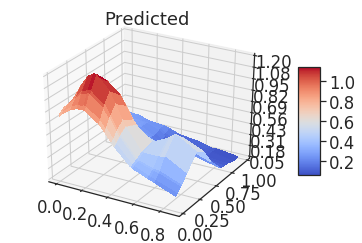

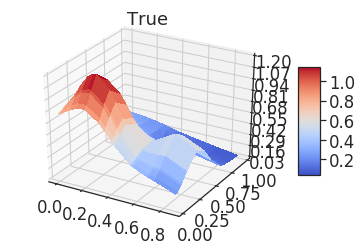

Mean squared error: 0.0000
R2 score: 0.9995


ValueError: too many values to unpack (expected 2)

In [93]:
# Testing class

'''
x = np.arange(0, 1, .05)#0.05)
y = np.arange(0, 1, .05)#0.05)
'''
np.random.seed(1)
observationNumber = 20
x = np.random.rand(observationNumber, 1)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)

xPlot, yPlot = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

zPlot = FrankeFunction(xPlot, yPlot)
degree = 10
ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
ls.createDesignMatrix()

ls.estimate()
#ls.fit()
ls.predict()
ls.plot()
ls.calculateErrorScores()
ls.calculateVarianceBeta()

#print('\n Theoretical Var(beta) training set \n', ls.varBeta, '\n')
ls.errorBootstrap(bootstraps=100, plot=True)

print('\n np.mean(ls.mseBootstrap) \n', np.mean(ls.mseBootstrap), '\n')

print('\n bias2, variance, noise, sum(bias2, variance, noise), totalError', 
              ls.bias2, ls.variance, ls.noise, ls.bias2+ ls.variance+ls.noise, ls.totalError)

#print('\n Bootstrap Var(Beta) \n', ls.varianceBetaBootstrap[-1], '\n')

#print('\n Variance diagonal', ls.varOLS, '\n')


#np.savetxt('XHat', ls.XHat)

#print('\n Var(Beta): (boot/theory-1)*100 \n', (ls.varianceBetaBootstrap[-1]/ls.varBeta-1)*100, '\n')

#print('\n (MSEtotal VBT/MSE-1)*100 \n', (ls.VBT/ls.mseBootstrap-1)*100)

#print('\n (MSEtotal VBT/erro2-1)*100 \n', (ls.VBT/ls.error2-1)*100)


The plot above shows tha there is a huge difference between the predicted and the true solution in a small area of the domain. At most the predicted solution is approximately 20 times larger than the true solution. The error scores are very good. However, looking at the figure above, we see that low error scores are no guarantee for the fit being good over the whole domain.

### Sci-kit learn: test

################### Sci-kit learn############################
Intercept:  0.5481633661827785
Coefficients:  [  0.           5.74654984   2.99559795 -24.03100583 -11.2601328
  -5.9653651   25.93438393  33.66372884  18.50345617 -14.08913347
  -0.90760655 -42.65810161  -1.189173   -31.71166945  36.40198929
  -7.37090174  15.88544529   6.62934981  -5.92131254  18.508273
 -19.78809639]
Mean squared error: 0.0022
R2 score: 0.9730

################### My class############################
OLS shape beta  (21,) type beta <class 'numpy.ndarray'>
shape beta  (21,) type beta <class 'numpy.ndarray'>
betaHat my class:  [  0.54816337   5.74654984   2.99559795 -24.03100583 -11.2601328
  -5.9653651   25.93438393  33.66372884  18.50345617 -14.08913347
  -0.90760655 -42.65810161  -1.189173   -31.71166945  36.40198929
  -7.37090174  15.88544529   6.62934981  -5.92131254  18.508273
 -19.78809639]
Mean squared error: 0.0022
R2 score: 0.9730
Predictions: zPredict/predictScitKit 
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 

/home/k/.local/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


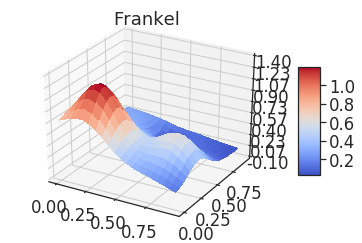

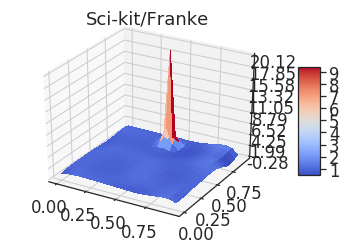

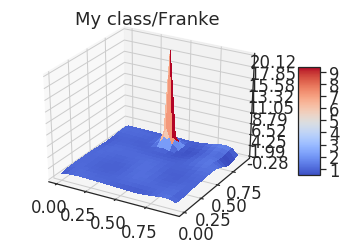

In [103]:
# Scitkit learn. Testing whether our code gives the same mse and R2 on the training set as scl.
from sklearn.linear_model import LinearRegression

x = np.arange(0, 1, .05)#0.05)
y = np.arange(0, 1, .05)#0.05)

xPlot, yPlot = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

zPlot = FrankeFunction(xPlot, yPlot)

x = np.reshape(xPlot, -1, 1)
y = np.reshape(yPlot, -1, 1)
z = np.reshape(zPlot, -1, 1)


XHat = np.c_[x, y]
degree = 5
polynomialDegree = degree
poly = PolynomialFeatures(polynomialDegree)
XHat = poly.fit_transform(XHat)

print('################### Sci-kit learn############################')
linreg = LinearRegression()
linreg.fit(XHat, z)
predictScitKit = linreg.predict(XHat)


print('Intercept: ', linreg.intercept_)
print('Coefficients: ', linreg.coef_)
print("Mean squared error: %.4f" % mean_squared_error(z, predictScitKit))
print('R2 score: %.4f' % r2_score(z, predictScitKit))

print('\n################### My class############################')

ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
ls.createDesignMatrix()
ls.estimate()
print('betaHat my class: ', ls.betaHat)
ls.predict()
ls.calculateErrorScores()
print('Predictions: zPredict/predictScitKit \n', ls.zPredict/predictScitKit)
print('XHat my class from outside/Xhat before into class \n', ls.XHat/XHat)


##############################PLOTS###################################
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xPlot, yPlot, zPlot, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Frankel')
plt.show()

predictScitKitPlot = np.reshape(predictScitKit, np.shape(yPlot)).T
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xPlot, yPlot, predictScitKitPlot/zPlot, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Sci-kit/Franke')
plt.show()

predictMyClassPlot = np.reshape(ls.zPredict, np.shape(yPlot)).T
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xPlot, yPlot, predictMyClassPlot/zPlot, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('My class/Franke')
plt.show()


## Bias-variance trade-off


 bias [0.03484549937863593, 0.04887699684082929, 0.0366117286494283, 0.056184058203518586, 0.08600778892780937, 0.12301201598513639] 
 variance [0.0014543672776745945, 0.0023092495245935164, 0.003834747641461316, 0.004196562508247853, 0.006337292426590169, 0.0048760738387997795] 
 noise [0.17065239141351923, 0.17065239141351923, 0.17065239141351923, 0.17065239141351923, 0.17065239141351923, 0.17065239141351923] 
 totalError [0.16938347827242164, 0.14766182266167932, 0.1411126803299772, 0.12661739739606456, 0.10616898361007326, 0.06347937162428932]


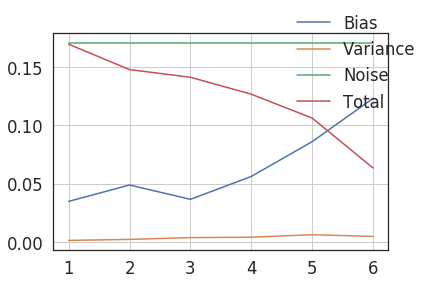

In [25]:
np.random.seed(1)
observationNumber = 20
x = np.random.rand(observationNumber, 1)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)

xPlot, yPlot = np.meshgrid(x,y)
zPlot = FrankeFunction(xPlot, yPlot)

def frankeNoise(z, noiseSize):
    return z+ noiseSize*np.random.randn(len(z))

noiseSize  = 0.5

zPlot = frankeNoise(zPlot, noiseSize)

maxDegree = 7
degrees = np.arange(1, maxDegree)
bootstraps = 1000
bias, variance, noise, totalError = [], [], [], []
for degree in degrees:
    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    #ls.createDesignMatrix()
    #ls.estimate()
    #ls.predict()
    #ls.plot()
    #ls.calculateErrorScores()
    #ls.calculateVarianceBeta()
    ls.errorBootstrap(bootstraps=bootstraps, plot=False)
    bias.append(ls.bias2)
    variance.append(ls.variance)
    noise.append(ls.noise)
    totalError.append(ls.totalError)
print('\n bias', bias, '\n variance', variance, '\n noise', noise, '\n totalError', totalError, )

fig, ax = plt.subplots()
legends = ['Bias', 'Variance', 'Noise', 'Total']
variables = [bias, variance, noise, totalError]
for i in range(len(variables)):
    ax.plot(degrees, variables[i], label=legends[i])
fig.legend(legends)


 bias [2.384563946628943] 
 variance [0.0017185537653078902] 
 noise [24.46648545018261] 
 totalError [26.93949182048812] 
 totalErrorForTesting [26.852767950576858] 
 totalError2 [548330.7634100948]


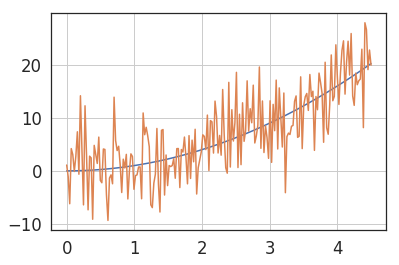

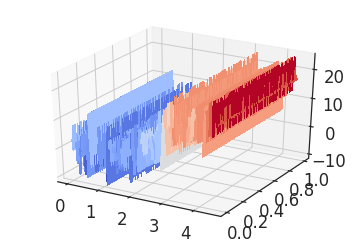

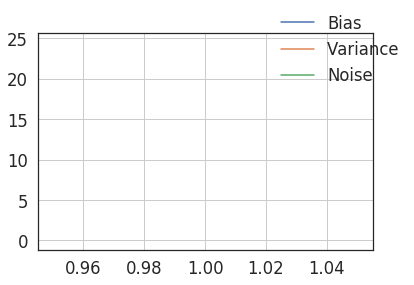

In [31]:
# Testing other function
def f(x, y):
    #z = 2 * np.sin(x * 1.5)
    z = x**2
    return z

def fWithNoise(z):
    z = z+ 5.*np.random.randn(len(z))
    return z

observationNumber = 200
x = np.linspace(0, 4.5, observationNumber)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)

fig, ax  = plt.subplots()
z2 = f(x,y)
ax.plot(x, z2)
ax.plot(x, fWithNoise(z2))


xPlot, yPlot = np.meshgrid(x,y)
zPlot = f(xPlot, yPlot)
zPlot = fWithNoise(zPlot)


fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xPlot, yPlot, zPlot, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)



maxDegrees = 2
degrees = np.arange(1, maxDegrees)
bootstraps = 100
bias, variance, noise, totalError, totalErrorForTesting, totalError2 = [], [], [], [], [], []
for degree in degrees:
    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=f)
    #ls.createDesignMatrix()
    #ls.estimate()
    #ls.fit()
    #ls.predict()
    #ls.plot()
    #ls.calculateErrorScores()
    #ls.calculateVarianceBeta()
    ls.errorBootstrap(bootstraps=bootstraps, plot=False)
    bias.append(ls.bias2)
    variance.append(ls.variance)
    noise.append(ls.noise)
    totalError.append(ls.totalError)
    totalErrorForTesting.append(ls.totalErrorForTesting)
    totalError2.append(ls.error2)
print('\n bias', bias, '\n variance', variance, '\n noise', noise, '\n totalError', totalError, \
      '\n totalErrorForTesting', totalErrorForTesting, '\n totalError2', totalError2, )

fig, ax = plt.subplots()
legends = ['Bias', 'Variance', 'Noise', 'Total']
variables = [bias, variance, noise, totalError]
for i in range(len(variables)-1):
    ax.plot(degrees, variables[i], label=legends[i])
fig.legend(legends)

# Ridge

In [49]:
degree = 10
lambdaValues = 0, .1, 1., 10, 100
for lambdaValue in lambdaValues:
    print('\n Lambda %.2f' %lambdaValue, '\n')
    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction, lambdaValue=lambdaValue)
    ls.createDesignMatrix()
    ls.estimate()
    print('betaHat my class: \n', ls.betaHat)
    ls.predict()
    ls.calculateErrorScores()


 Lambda 0.00 

betaHat my class: 
 [ 7.26250379e-01  2.88287305e+00  2.03880949e+00 -2.61453344e+01
 -7.44684487e+01 -1.36075899e+01  1.90553467e+02  7.55956432e+02
  8.54439102e+02 -7.02212262e+00 -1.05991656e+03 -3.28073794e+03
 -5.42808002e+03 -3.73245279e+03  6.27026111e+02  3.76128587e+03
  8.35333647e+03  1.62510092e+04  1.78407391e+04  7.74972805e+03
 -4.04145484e+03 -8.86526968e+03 -1.66005232e+04 -2.82898721e+04
 -3.66050434e+04 -3.09899839e+04 -8.42287076e+03  1.24360892e+04
  1.40517938e+04  2.91925282e+04  2.74238699e+04  4.58082870e+04
  4.74932680e+04  2.66261484e+04  5.73221046e+03 -2.14192508e+04
 -1.42467961e+04 -3.77607121e+04 -9.74367982e+03 -4.27725470e+04
 -2.94925950e+04 -3.96180881e+04 -6.33829837e+03 -4.31794400e+03
  2.11577818e+04  8.22394185e+03  2.78346578e+04 -3.20482272e+03
  2.25555666e+04  1.37451063e+04  1.36926504e+04  1.66429004e+04
 -4.40832251e+03  3.34945914e+03 -1.12275171e+04 -2.03462117e+03
 -8.43723882e+03  2.04066298e+03 -2.91203644e+03 -7.45

In [56]:
# Ridge and bootstrap
maxDegrees = 10
degrees = np.arange(1, maxDegrees)
bootstraps = 100
bias, variance, noise, totalError, totalErrorForTesting, totalError2 = [], [], [], [], [], []
lambdaValues = 0, 10
noiseValues = 0, 0.5
for noiseValue in noiseValues:
    print('\n Noise: %.2f' %noiseValue, '\n')
    zPlotInput = frankeNoise(zPlot, noiseValue)
    for lambdaValue in lambdaValues:
        print('\n Lambda %.2f' %lambdaValue, '\n')
        for degree in degrees:
            ls = LeastSquares(xPlot, yPlot, zPlotInput, degree,trueFunction=FrankeFunction, lambdaValue=lambdaValue)
            #ls.createDesignMatrix()
            #ls.estimate()
            #ls.predict()
            #ls.plot()
            #ls.calculateErrorScores()
            #ls.calculateVarianceBeta()
            ls.errorBootstrap(bootstraps=bootstraps, plot=False)
            bias.append(ls.bias2)
            variance.append(ls.variance)
            noise.append(ls.noise)
            totalError.append(ls.totalError)
        print('\n bias', bias, '\n variance', variance, '\n noise', noise, '\n totalError', totalError,'\n' )


 Noise: 0.00 


 Lambda 0.00 


 bias [0.020752055062280107, 0.01663575189760486, 0.0058842216464927224, 0.0026827304984881795, 0.001574837635163821, 0.0007651658524831409, 0.0005061962779104066, 0.00032920193978261424, 0.0007612100705668432] 
 variance [0.00019703927582549147, 0.00027854219117030214, 0.0001702517268844755, 0.00017231670198249527, 0.0001691164655527666, 0.0003106347550999, 0.0003221198861114912, 0.0003193882604039804, 0.0019148736185666526] 
 noise [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 
 totalError [0.020949094338105597, 0.01691429408877516, 0.0060544733733771975, 0.002855047200470675, 0.0017439541007165877, 0.001075800607583041, 0.0008283161640218979, 0.0006485902001865946, 0.0026760836891334956] 


 Lambda 10.00 


 bias [0.020752055062280107, 0.01663575189760486, 0.0058842216464927224, 0.0026827304984881795, 0.001574837635163821, 0.0007651658524831409, 0.0005061962779104066, 0.00032920193978261424, 0.0007612100705668432, 0.029263310496706118, 0.026076975021